In [1]:
from feos_pcsaft.si import *
from feos_pcsaft.dft import *
from feos_pcsaft import PcSaftParameters

import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor

# the following is only needed if you processpool executor
# does not start multiple processes
#import psutil
#p = psutil.Process()
#p.cpu_affinity(list(range(psutil.cpu_count())))

In [2]:
params = PcSaftParameters.from_json(["methanol"], "adsorption_params.json")
func = PcSaftFunctional(params)

# Phase equilibria in pores

In [3]:
potential = ExternalPotential.LJ93(3.0, 100.0, 0.08)
pore = Pore1D(func, Geometry.Cartesian, 20*ANGSTROM, potential)

pmin = 0.2*BAR
pmax = 2.5*BAR
pressures = np.array([0.3, 0.6, 1.0, 1.2, 1.5, 2.0]) * BAR

isotherm1 = Adsorption1D.adsorption_isotherm(func, 350*KELVIN, (pmin, pmax, 151), pore)
points1 = Adsorption1D.adsorption_isotherm(func, 350*KELVIN, pressures, pore)

isotherm2 = Adsorption1D.desorption_isotherm(func, 350*KELVIN, (pmin, pmax, 151), pore)
points2 = Adsorption1D.desorption_isotherm(func, 350*KELVIN, pressures, pore)

isotherm3 = Adsorption1D.equilibrium_isotherm(func, 350*KELVIN, (pmin, pmax, 151), pore)
points3 = Adsorption1D.equilibrium_isotherm(func, 350*KELVIN, pressures, pore)

equilibrium = Adsorption1D.phase_equilibrium(func, 350*KELVIN, pmin, pmax, pore)

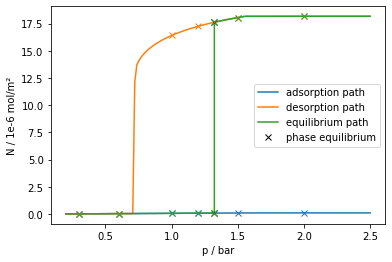

In [4]:
plt.plot(isotherm1.pressure/BAR, isotherm1.total_adsorption/(MICRO*MOL/METER**2))
plt.plot(isotherm2.pressure/BAR, isotherm2.total_adsorption/(MICRO*MOL/METER**2))
plt.plot(isotherm3.pressure/BAR, isotherm3.total_adsorption/(MICRO*MOL/METER**2))
plt.plot(equilibrium.pressure/BAR, equilibrium.total_adsorption/(MICRO*MOL/METER**2), 'xk')
plt.gca().set_prop_cycle(None)
plt.plot(points1.pressure/BAR, points1.total_adsorption/(MICRO*MOL/METER**2), 'x')
plt.plot(points2.pressure/BAR, points2.total_adsorption/(MICRO*MOL/METER**2), 'x')
plt.plot(points3.pressure/BAR, points3.total_adsorption/(MICRO*MOL/METER**2), 'x')
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

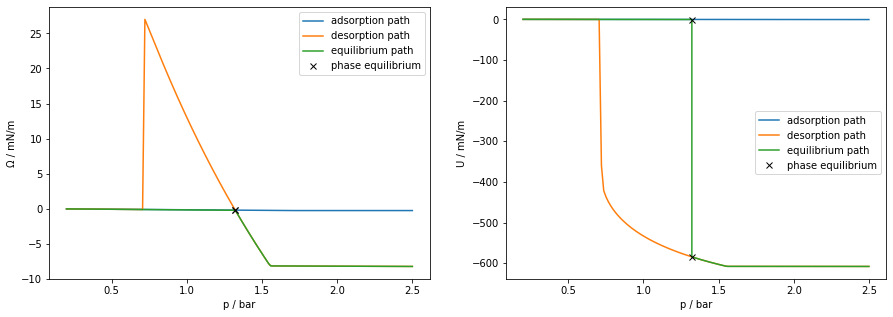

In [5]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm1.pressure/BAR, isotherm1.grand_potential/(MILLI*NEWTON/METER))
ax[0].plot(isotherm2.pressure/BAR, isotherm2.grand_potential/(MILLI*NEWTON/METER))
ax[0].plot(isotherm3.pressure/BAR, isotherm3.grand_potential/(MILLI*NEWTON/METER))
ax[0].plot(equilibrium.pressure/BAR, equilibrium.grand_potential/(MILLI*NEWTON/METER), 'xk')
ax[0].set_xlabel('p / bar')
ax[0].set_ylabel('Ω / mN/m')
ax[0].legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

def U(isotherm):
    return [p.internal_energy()/(MILLI*NEWTON/METER) for p in isotherm.profiles]

ax[1].plot(isotherm1.pressure/BAR, U(isotherm1))
ax[1].plot(isotherm2.pressure/BAR, U(isotherm2))
ax[1].plot(isotherm3.pressure/BAR, U(isotherm3))
ax[1].plot(equilibrium.pressure/BAR, U(equilibrium), 'xk')
ax[1].set_xlabel('p / bar')
ax[1].set_ylabel('U / mN/m')
ax[1].legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

# Enthalpy of adsorption

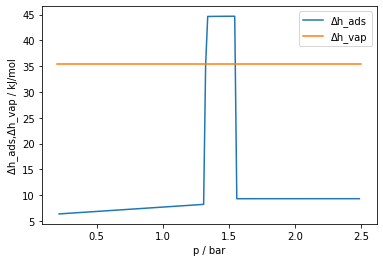

In [6]:
def adsorption_enthalpy(isotherm):
    profiles = isotherm.profiles
    h_ads = []
    p = []
    for p1,p2,p3 in zip(profiles,profiles[1:],profiles[2:]):
        dU = p3.internal_energy() - p1.internal_energy()
        dN = p3.total_moles - p1.total_moles
        h_ads.append((p2.bulk.molar_enthalpy() - dU/dN)/(KILO*JOULE/MOL))
        p.append(p2.bulk.pressure()/BAR)
    return p, h_ads

plt.plot(*adsorption_enthalpy(isotherm3))


vle = PhaseEquilibrium.pure_t(func, 350*KELVIN)
h_vap = (vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy())/(KILO*JOULE/MOL)
plt.plot([pmin/BAR, pmax/BAR],[h_vap,h_vap])
plt.xlabel('p / bar')
plt.ylabel('Δh_ads,Δh_vap / kJ/mol')
plt.legend(['Δh_ads', 'Δh_vap']);

# Variation of pore width

In [7]:
def plt_iso(L):
    isotherm = Adsorption1D.equilibrium_isotherm(func, 350*KELVIN, (0.5*BAR, 2*BAR, 200), Pore1D(func, Geometry.Cartesian, L*ANGSTROM, potential))
    return isotherm.pressure/BAR, isotherm.total_adsorption/(MICRO*MOL/METER**2)

L_vec = np.linspace(10,40,7)
with ProcessPoolExecutor() as ex:
    isotherms = [i for i in ex.map(plt_iso, L_vec)]

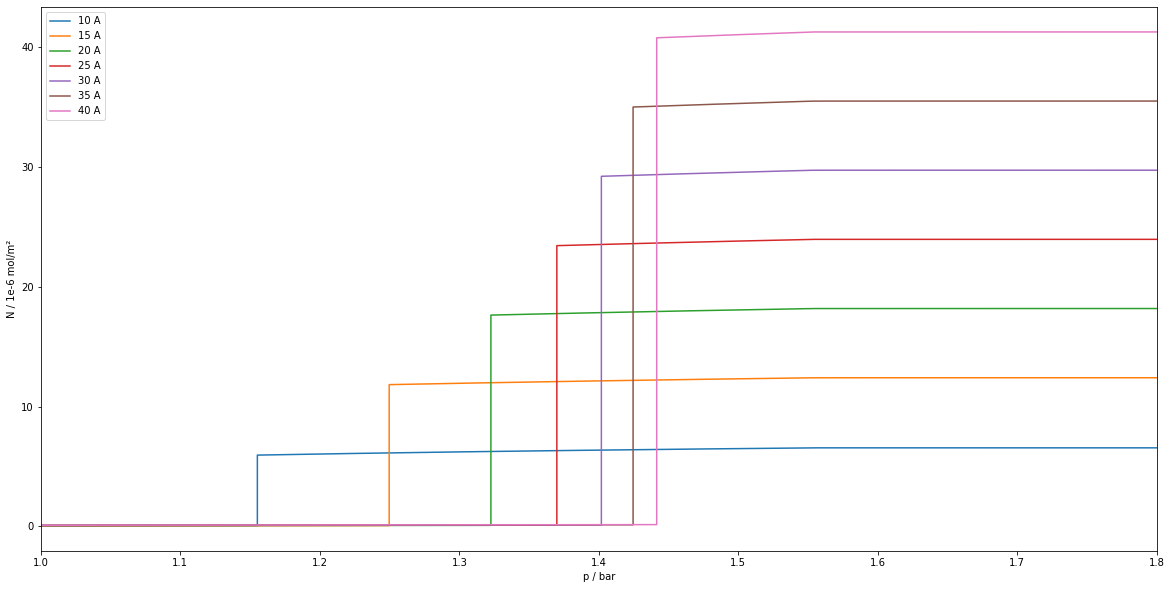

In [8]:
f, ax = plt.subplots(figsize=(20,10))
for p,a in isotherms:
    ax.plot(p,a)
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f'{w:g} A' for w in L_vec]);
plt.xlim(1,1.8);

# Variation of $\varepsilon$-parameter

In [9]:
%%time
def plt_iso(epsilon):
    potential = ExternalPotential.LJ93(3.0, epsilon, 0.08)
    isotherm = Adsorption1D.equilibrium_isotherm(func, 350*KELVIN, (0.5*BAR, 2*BAR, 200), Pore1D(func, Geometry.Cartesian, 20*ANGSTROM, potential))
    return isotherm.pressure/BAR, isotherm.total_adsorption/(MICRO*MOL/METER**2)

eps_vec = np.linspace(70,150,9)
with ProcessPoolExecutor() as ex:
    isotherms = [i for i in ex.map(plt_iso, eps_vec)]

CPU times: user 41.1 ms, sys: 137 ms, total: 179 ms
Wall time: 9.76 s


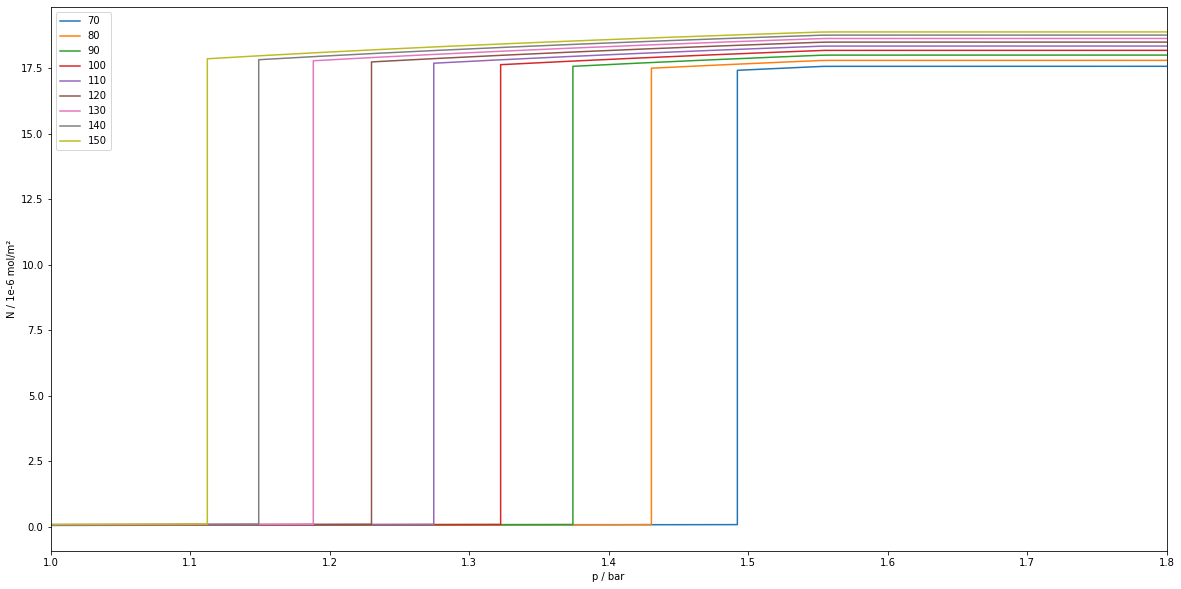

In [10]:
f, ax = plt.subplots(figsize=(20,10))
for p,a in isotherms:
    ax.plot(p,a)
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f'{e:g}' for e in eps_vec]);
plt.xlim(1,1.8);

# Variation of temperature

In [11]:
def plt_iso(T):
    potential = ExternalPotential.LJ93(3.0, 150., 0.08)
    vle = PhaseEquilibrium.pure_t(func, T*KELVIN)
    psat = vle.liquid.pressure()
    mu_fl = vle.liquid.chemical_potential()
    pmin = psat / 100
    pmax = psat * 2
    isotherm = Adsorption1D.equilibrium_isotherm(func, T*KELVIN, (pmin, pmax, 200), Pore1D(func, Geometry.Cartesian, 20*ANGSTROM, potential))
    A = [((mu_fl - p.bulk.chemical_potential())/(JOULE/MOL))[0] for p in isotherm.profiles]
    return isotherm.pressure/BAR, isotherm.total_adsorption/(MICRO*MOL/METER**2), isotherm.grand_potential/(MILLI*NEWTON/METER), A, isotherm.profiles[-1].total_moles/(MICRO*MOL/METER**2)

T_vec = np.linspace(290,430,15)
with ProcessPoolExecutor() as ex:
    isotherms = [i for i in ex.map(plt_iso, T_vec)]

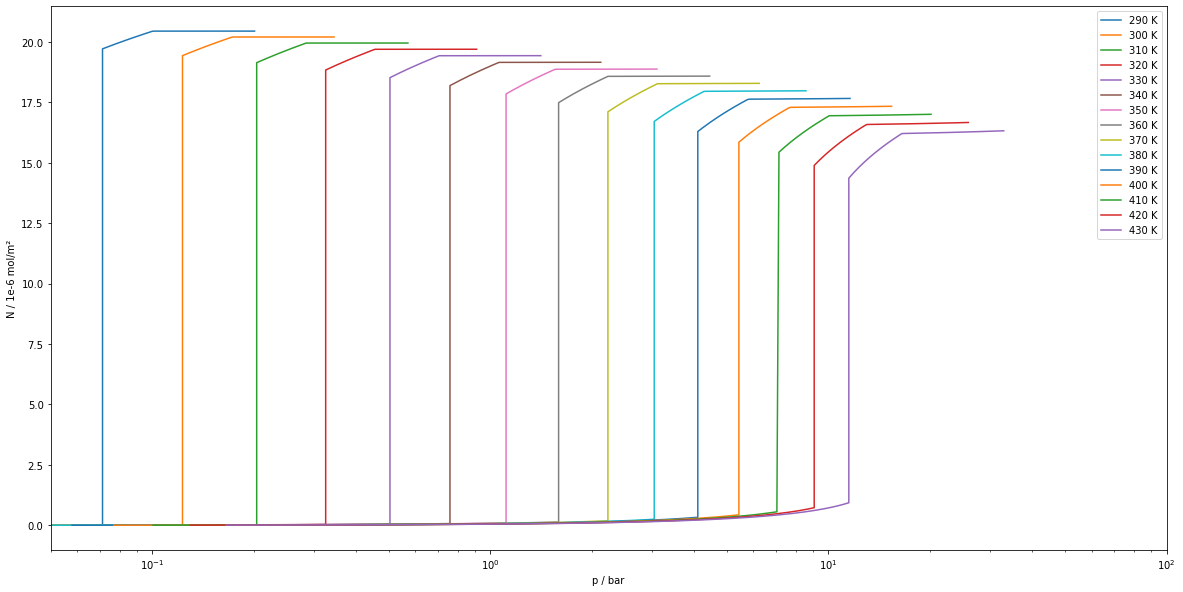

In [12]:
f, ax = plt.subplots(figsize=(20,10))
for p,a,_,_,_ in isotherms:
    ax.semilogx(p,a)
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f"{T:g} K" for T in T_vec]);
plt.xlim(0.05,100);

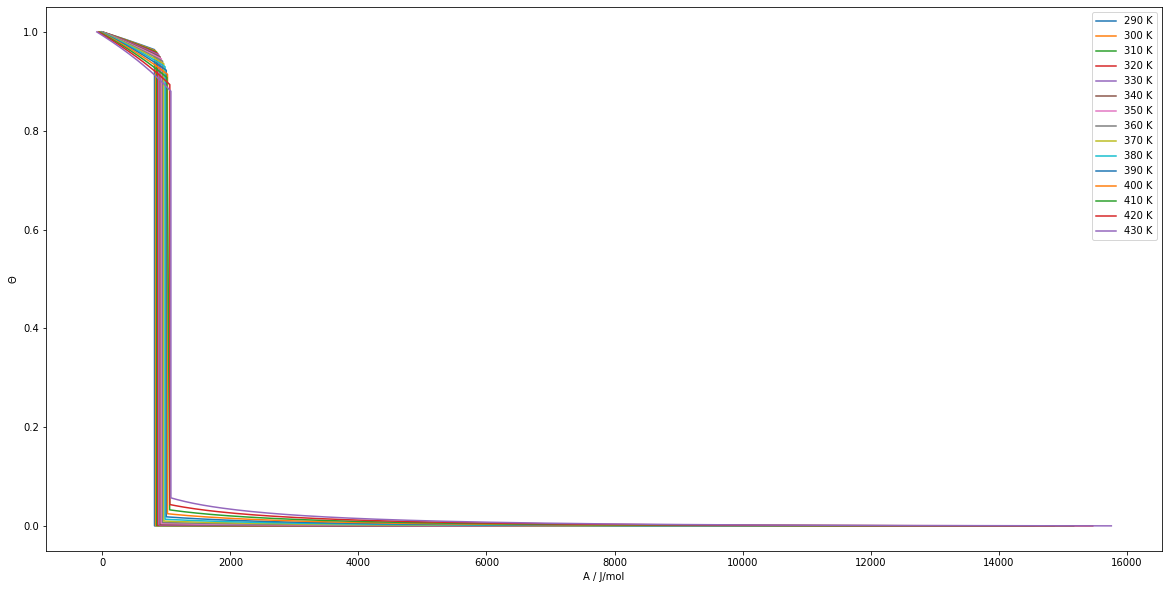

In [13]:
f, ax = plt.subplots(figsize=(20,10))
for _,W,_,A,W0 in isotherms:
    ax.plot(A,W/W0)
plt.xlabel('A / J/mol')
plt.ylabel('$\Theta$')
plt.legend([f"{T:g} K" for T in T_vec]);
#plt.xlim(0.05,150);

# Binary mixture

In [14]:
mix = PcSaftFunctional(PcSaftParameters.from_json(["methanol", "ethanol"], "adsorption_params.json"))
methanol = PcSaftFunctional(PcSaftParameters.from_json(["methanol"], "adsorption_params.json"))
ethanol  = PcSaftFunctional(PcSaftParameters.from_json(["ethanol"], "adsorption_params.json"))

In [15]:
potential = ExternalPotential.LJ93(3.0, 100.0, 0.08)
pmin = 0.2*BAR
pmax = 1.8*BAR

isotherm_ethanol = Adsorption1D.equilibrium_isotherm(ethanol, 350*KELVIN, (pmin, pmax, 151), Pore1D(ethanol, Geometry.Cartesian, 20*ANGSTROM, potential))
isotherm_methanol = Adsorption1D.equilibrium_isotherm(methanol, 350*KELVIN, (pmin, pmax, 151), Pore1D(methanol, Geometry.Cartesian, 20*ANGSTROM, potential))
isotherm_mix = Adsorption1D.equilibrium_isotherm(mix, 350*KELVIN, (pmin, pmax, 151), Pore1D(mix, Geometry.Cartesian, 20*ANGSTROM, potential), np.array([0.5, 0.5]))

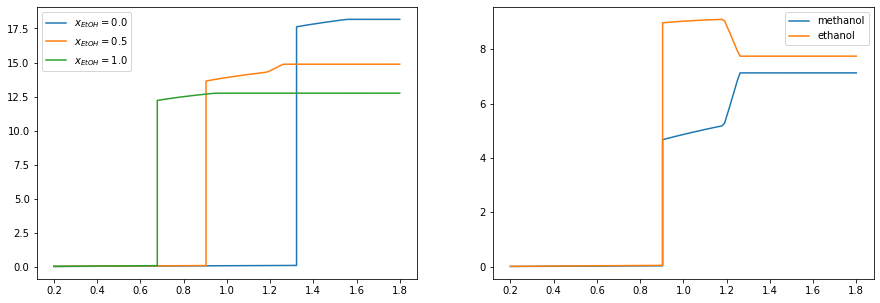

In [16]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm_methanol.pressure/BAR, isotherm_methanol.total_adsorption/(MICRO*MOL/METER**2))
ax[0].plot(isotherm_mix.pressure/BAR, isotherm_mix.total_adsorption/(MICRO*MOL/METER**2))
ax[0].plot(isotherm_ethanol.pressure/BAR, isotherm_ethanol.total_adsorption/(MICRO*MOL/METER**2))
ax[0].legend(['$x_{EtOH}=0.0$', '$x_{EtOH}=0.5$', '$x_{EtOH}=1.0$']);

ax[1].plot(isotherm_mix.pressure/BAR, (isotherm_mix.adsorption/(MICRO*MOL/METER**2)).T)
ax[1].legend(['methanol', 'ethanol']);

In [17]:
equilibrium = Adsorption1D.phase_equilibrium(mix, 350*KELVIN, pmin, pmax, Pore1D(mix, Geometry.Cartesian, 20*ANGSTROM, potential), np.array([0.5, 0.5]))

(0.0, 17.0)

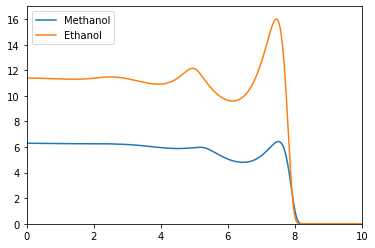

In [18]:
plt.plot(equilibrium.profiles[1].r/ANGSTROM, (equilibrium.profiles[1].density/(KILO*MOL/METER**3)).T)
plt.legend(["Methanol", "Ethanol"])
plt.xlim(0,10)
plt.ylim(0,17)

# External potentials

### Lennard-Jones 9-3

In [19]:
rho = 3.0e4
potential = ExternalPotential.LJ93(3.0, 90, 0.08)
s = State(func, 350*KELVIN, density=rho*MOL/METER**3)
profile = Pore1D(func, Geometry.Cartesian, 20*ANGSTROM, potential).initialize(s).solve()

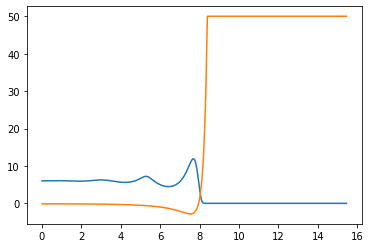

In [20]:
plt.plot(profile.r / ANGSTROM, (profile.density / (MOL  / METER**3))[0] / 5000)
plt.plot(profile.r / ANGSTROM, profile.external_potential[0])

### Double Well

In [21]:
potential = ExternalPotential.DoubleWell(3.0, 25, 150, 0.08)
s = State(func, 350*KELVIN, density=rho*MOL/METER**3)
profile = Pore1D(func, Geometry.Cartesian, 40*ANGSTROM, potential).initialize(s).solve()

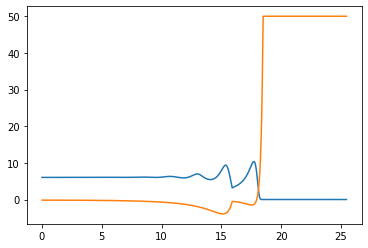

In [22]:
plt.plot(profile.r / ANGSTROM, (profile.density / (MOL  / METER**3))[0] / 5000)
plt.plot(profile.r / ANGSTROM, profile.external_potential[0])

# DFTSolver options

In [23]:
# create a list of solvers that are called consecutively
solver = DFTSolver().picard_iteration(tol=1e-5).anderson_mixing(max_iter=400)
solver

|solver|log|max_iter|tol|beta|mmax|max_rel|
|-|:-:|-:|-:|-:|-:|-:|
|Picard Iteration||500|1e-5|0.15||1|
|Anderson Mixing||400|1e-11|0.15|100||